In [1]:
]activate ../../../

  Activating project at `~/UCLOneDrive/SpatialStructureInMicrobialCommunities/SSMCCode`


In [2]:
using Revise
includet("./base.jl")

In [3]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

In [4]:
import DataFrames: metadata as md

# Setup

In [82]:
function plot_spatial_fs!(gl, u, Ns, sN, dx;
    axis=(;),
)
    Nr = size(u)[1] - Ns
    xs = ((1:sN) .- 0.5) .* dx
    
    axs = Axis(gl[1,1]; axis...)
    axr = Axis(gl[2,1]; axis...)
    linkxaxes!(axs, axr)
    hidexdecorations!(axs)
    rowgap!(gl, 4.)

    for i in 1:Ns
        lines!(axs, xs, u[i,:])
    end
    for a in 1:Nr
        lines!(axr, xs, u[Ns+a,:])
    end

    axs, axr
end
function plot_spatial_fs(args...;
    figure=(;),
    kwargs...
)
    fig = Figure(; figure...)
    plot_spatial_fs!(fig, args...; kwargs...)

    fig
end

plot_spatial_fs (generic function with 2 methods)

# Make a base and high N0 spatial structure report

In [105]:
function make_spatial_report(df)
    N = md(df, "N")
    M = md(df, "M")
    T = md(df, "T")
    sN = md(df, "sN")
    dx = md(df, "dx")
    
    N0 = md(df, "N0")

    num_runs = nrow(df)
    fig = Figure(;
        size=(1000, 200*num_runs)
    )

    for i in 1:num_runs
        sr = df[i,:]
        
        bgl = GridLayout(fig[i,1])
        baxs, baxr = plot_spatial_fs!(bgl, sr.final_states, N, sN, dx)
        
        hN0gl = GridLayout(fig[i,2])
        hN0axs, hN0axr = plot_spatial_fs!(hN0gl, sr.highN0_final_states, N, sN, dx)
        
        # baxr.xlabel = "space"
        # hN0axr.xlabel = "space"
        
        Label(fig[i,0], "Params $i";
            tellheight=false,
            rotation=pi/2,
        )
    end
    Label(fig[0,1], "Starting from near homogeneous steady state"; tellwidth=false)
    Label(fig[0,2], "Starting from high N0=$(N0)"; tellwidth=false)

    rowgap!(fig.layout, 5.)

    fig
end

make_spatial_report (generic function with 1 method)

# Run 1 - both rslt_df1 and rslt_df2
- N=M=20
- pe=pei=0.15 <=> B = 3
- Ds are 1e-6, 1., 1.
- slightly varied lognormal m
- L=5 with 5000 grid points

In [31]:
# f = jldopen("./rslt_df1.jld2")
# f2 = jldopen("./rslt_df2.jld2")
# df = vcat(f["df"], f2["df"])
# close(f)
# close(f2)
f = jldopen("./rslt2_df1.jld2")
df = copy(f["df"])
close(f)


N = md(df, "N")
M = md(df, "M")
T = md(df, "T")
sN = md(df, "sN")
dx = md(df, "dx")

@printf "There are %d runs, of which %d near ss finished at T, and %d high N0 finished at T\n" nrow(df) count(==(T), df.final_Ts) count(==(T), df.highN0_final_Ts)
@show N, M;

There are 4 runs, of which 4 near ss finished at T, and 4 high N0 finished at T
(N, M) = (20, 20)


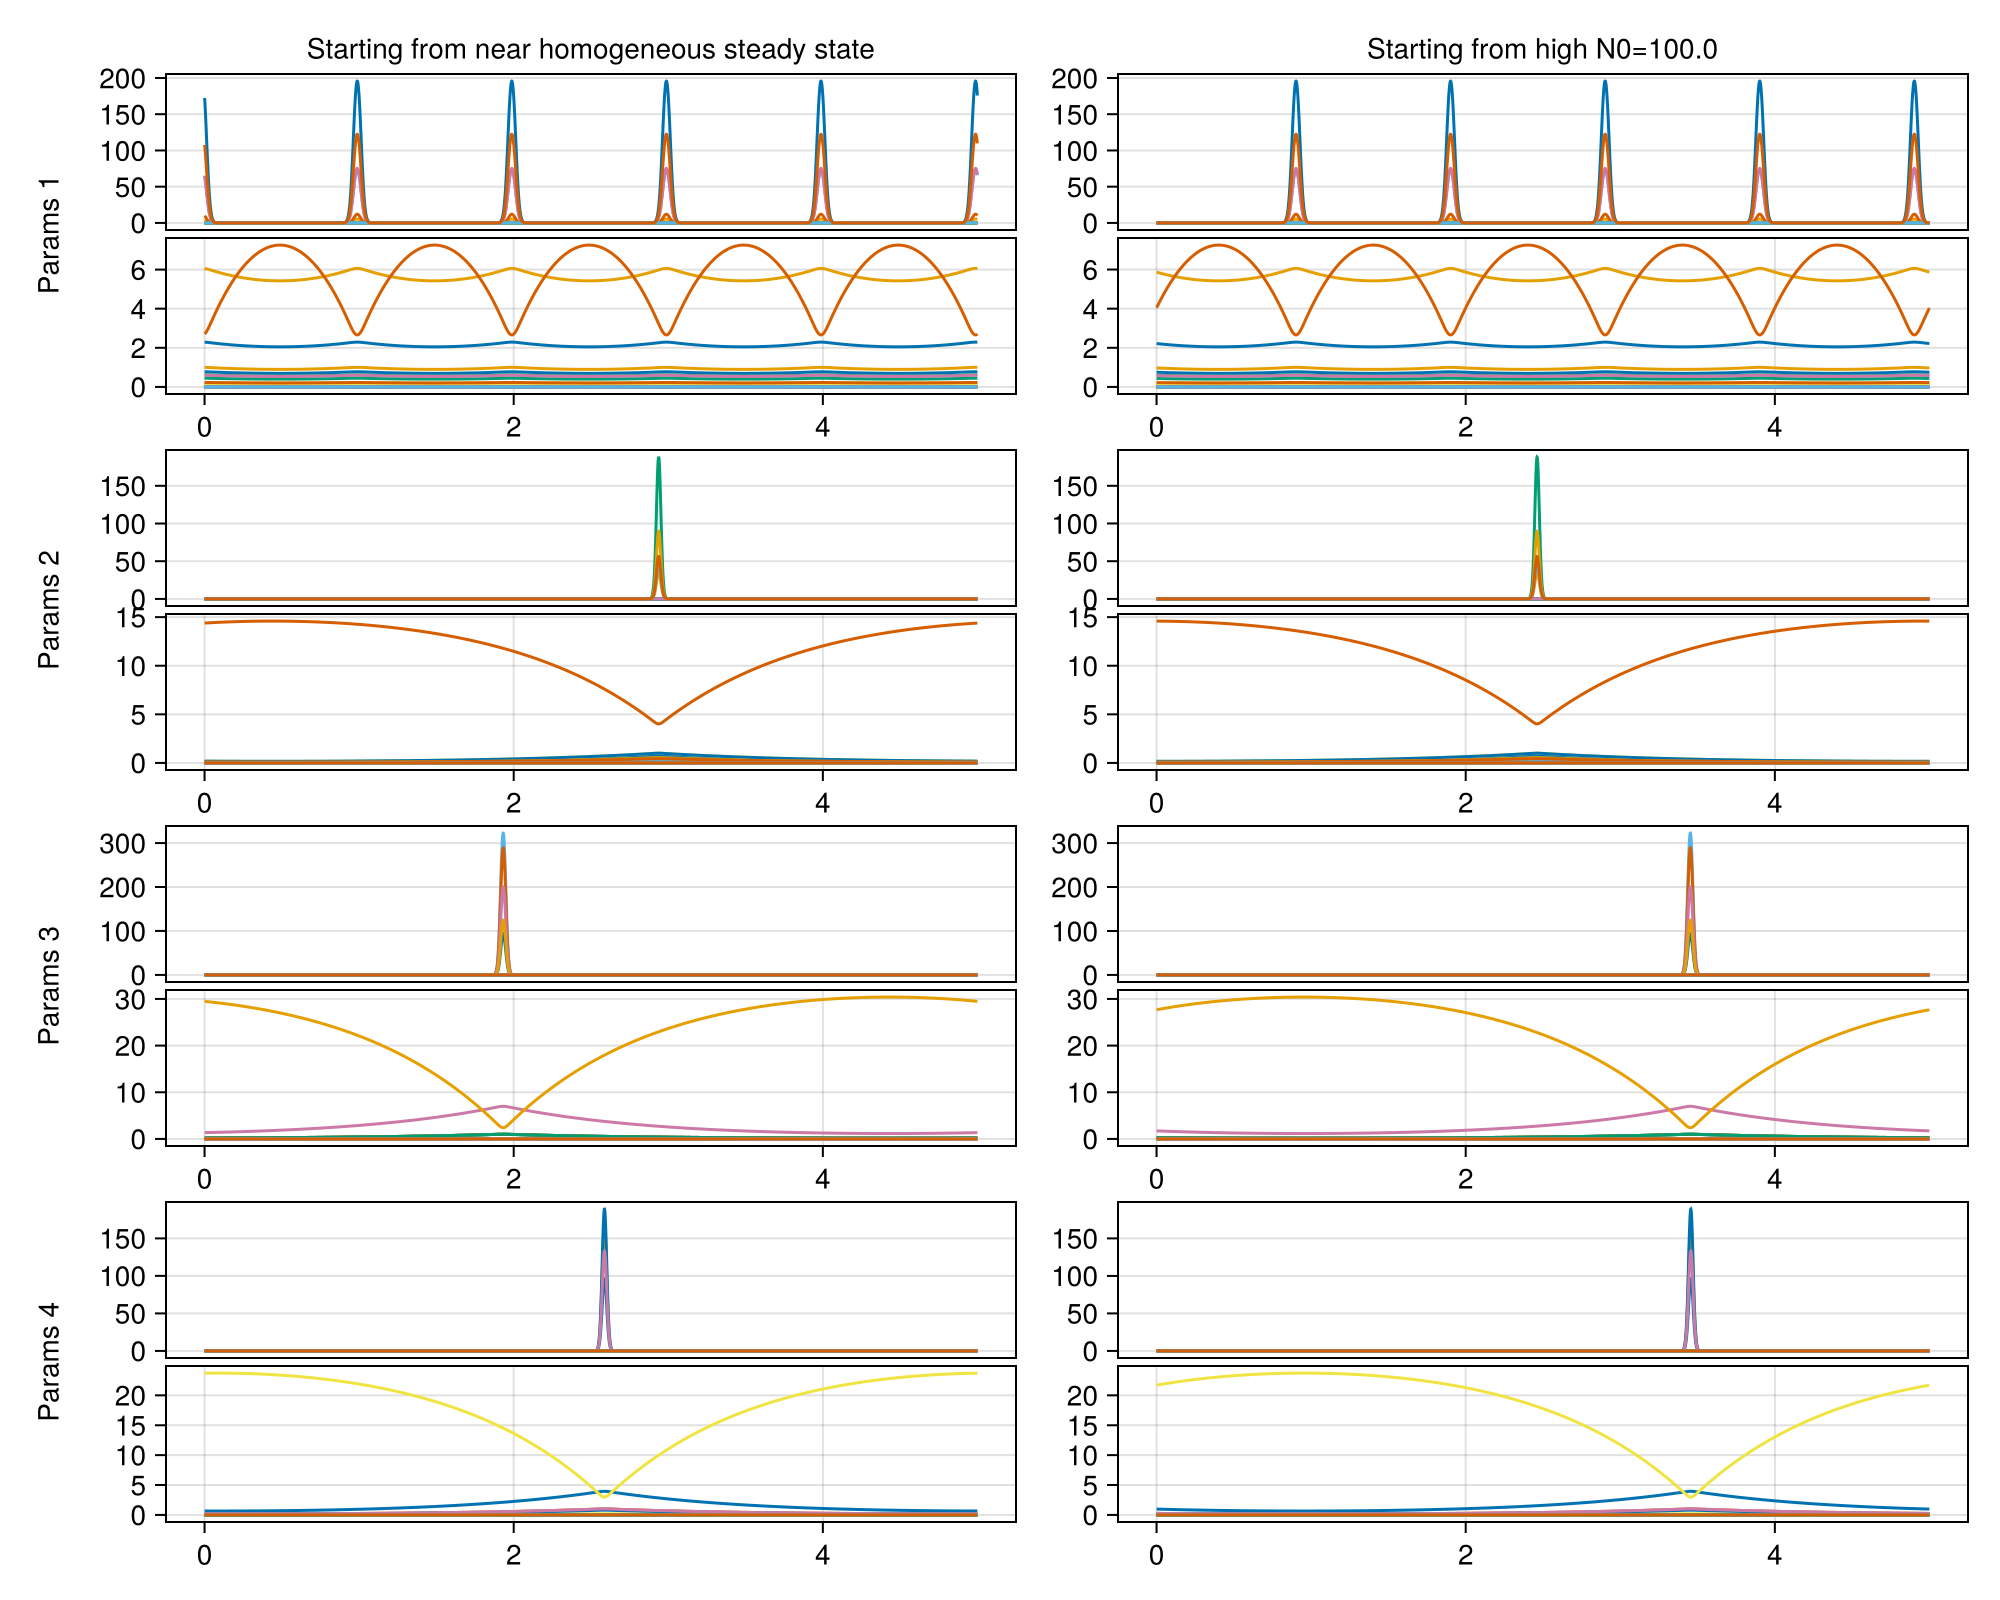

In [106]:
f = make_spatial_report(df)
Makie.save("./highN0_pdes_report1.pdf", f)
f

In [32]:
sr = rand(eachrow(df));

In [55]:
sr = df[1,:];

In [56]:
ps = sr.params
ss = sr.steadystates;
cmin = max(minimum(abs, ss), eps())
css = clamp.(ss, cmin, Inf);

### Spatial final state

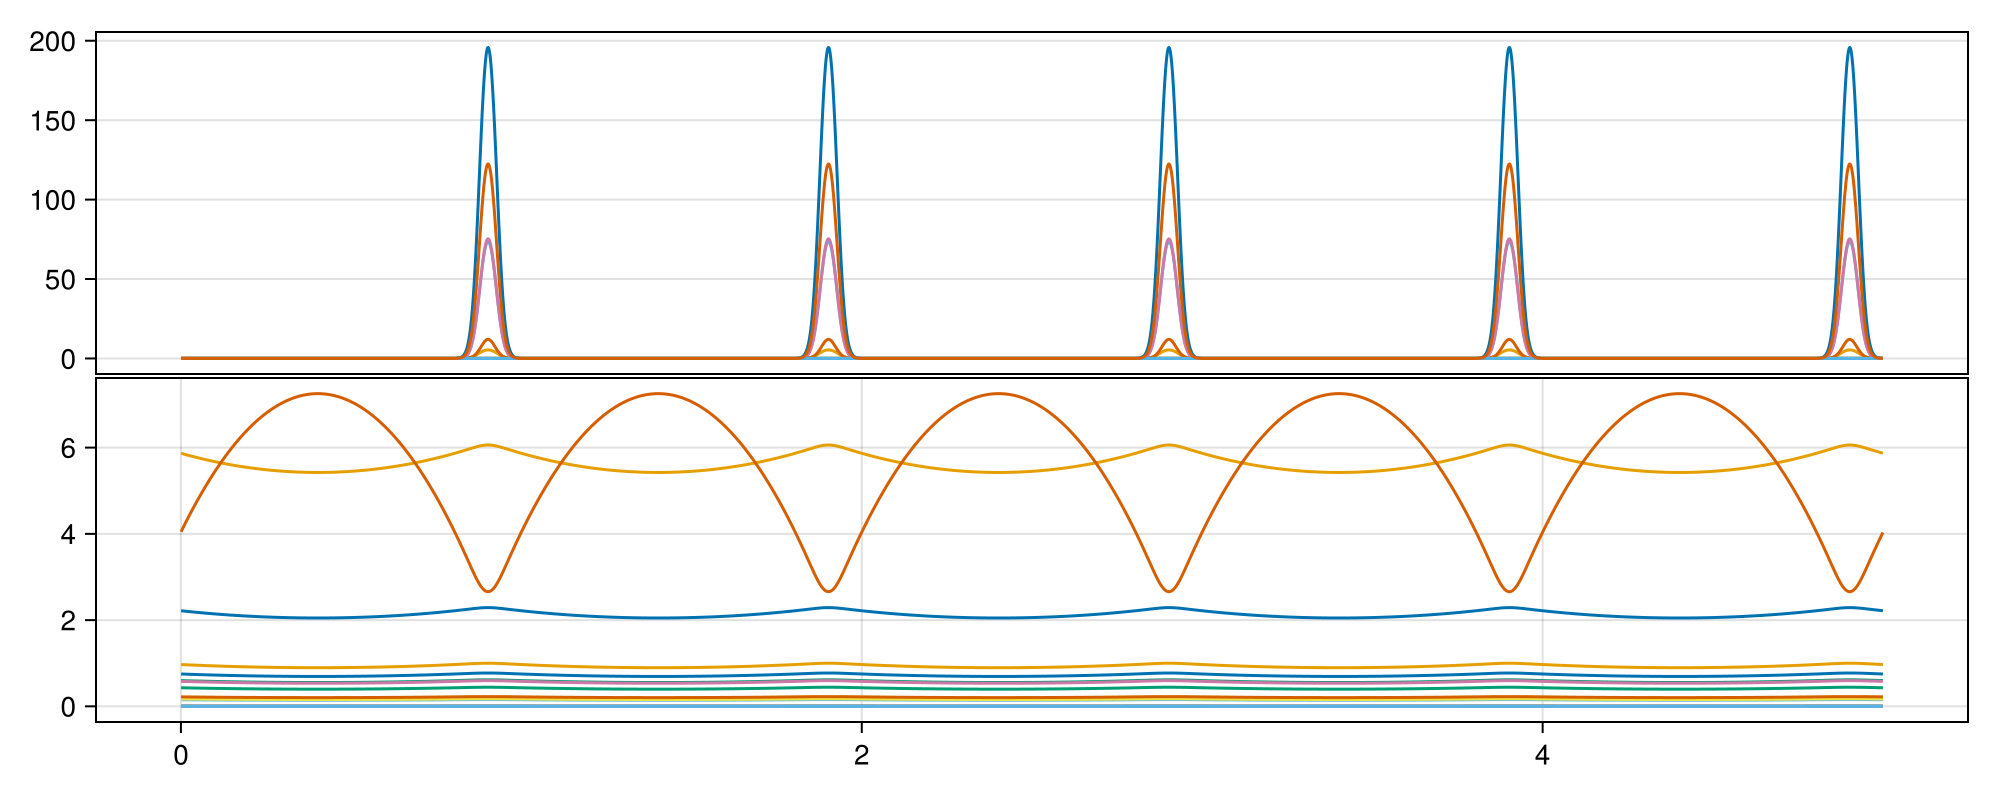

In [77]:
plot_spatial_fs(sr.highN0_final_states, N, sN, dx;
# plot_spatial_fs(sr.final_states, N, sN, dx;
    figure=(; size=(1000, 400))
)

### No-space ss and network structure

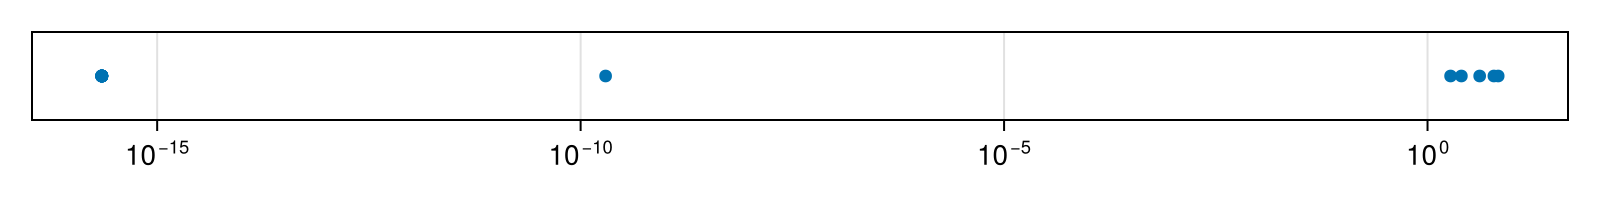

In [21]:
scatter(css[1:N], fill(1, N);
    figure=(; size=(800, 100)),
    axis=(;
        xscale=log10,
        yticks=([], [])
    )
)

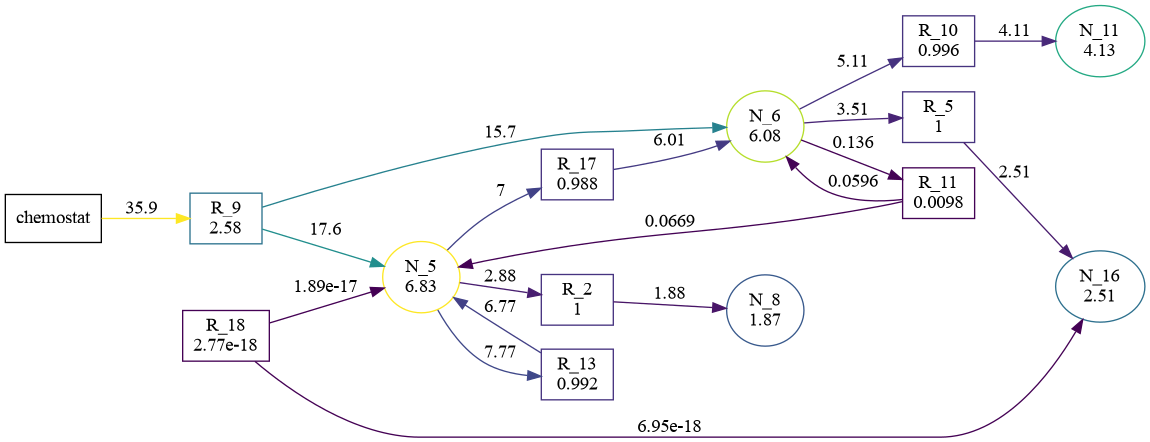

In [22]:
diagram_sfss_v3(sr.params, sr.steadystates;
    strain_threshold=1e-2,
    # colorscale=log10,
)

### Linstab

In [23]:
k_to_evals = linstab_make_k_func(ps, ss)
# ks = 10 .^ range(-5, 3, 100)
ks = range(0.001, 50, 1000)
@time evals = k_to_evals.(ks);

  0.043958 seconds (12.05 k allocations: 35.751 MiB)


[ Info: Unstable, mrl is 0.00234768


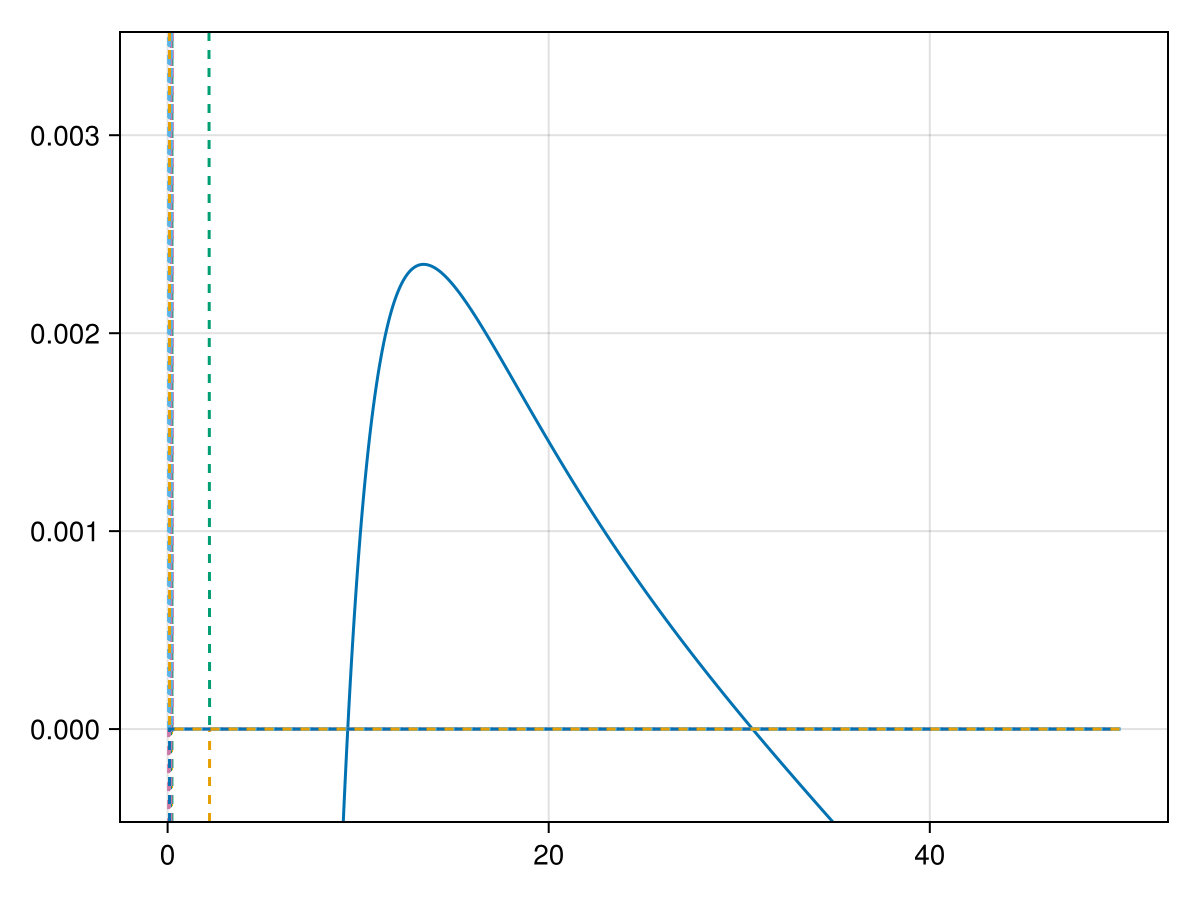

In [24]:
faa = plot_linstab_lambdas(ks, evals;
    axis=(;
        # xscale=log10
    ),
    legend=false
)

# display(GLMakie.Screen(), faa.figure)
faa